### Importing Dependencies

In [10]:
import os
import evaluate
import numpy as np
from dotenv import load_dotenv
from datasets import load_dataset
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from huggingface_hub import login

load_dotenv()
os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")
login_token = os.environ["HF_TOKEN"]
login(token=login_token)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


### Loading the Dataset

In [2]:
dataset_dict = load_dataset("shawhin/phishing-site-classification")

In [3]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 2100
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 450
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 450
    })
})

### Loading the Model

In [4]:
model_path = "google-bert/bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_path)

id2label = {0: "Safe", 1:"Not Safe"}
label2id = {"Safe":0, "Not Safe":1}

model = AutoModelForSequenceClassification.from_pretrained(model_path, 
                                                           num_labels = 2,
                                                           id2label=id2label, 
                                                           label2id=label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Unfreezing a few parameters

In [5]:
for name, param in model.base_model.named_parameters():
    param.requires_grad = False

for name, param in model.base_model.named_parameters():
    if "pooler" in name:
        param.requires_grad = True

### Preprocess the Dataset

In [6]:
def preprocess(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_data = dataset_dict.map(preprocess, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

### Helper Function to evaluate model

In [19]:
accuracy = evaluate.load("accuracy")
auc_score = evaluate.load("roc_auc")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    probabilities = np.exp(predictions) / np.exp(predictions).sum(-1, keepdims=True)

    positive_class_probs = probabilities[:, 1]

    auc = np.round(auc_score.compute(prediction_scores = positive_class_probs, 
                                     references=labels)['roc_auc'], 3)
    
    predicted_class = np.argmax(predictions, axis=1)

    acc = np.round(accuracy.compute(predictions=predicted_class,
                                    references=labels)['accuracy'], 3)
    
    return {"Accuracy": acc, "AUC": auc}

### Training

In [ ]:
lr = 2e-4
batch_size = 8
num_epochs = 20

training_args = TrainingArguments(
    output_dir="bert-pishing-classifier_teacher",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

In [9]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
train_output = trainer.train()

/var/folders/qt/5c37h5kx4mscm3d04cjbk4kw0000gn/T/ipykernel_15718/2556582153.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/5260 [00:00<?, ?it/s]

{'loss': 0.4932, 'grad_norm': 1.3125159740447998, 'learning_rate': 0.00019, 'epoch': 1.0}


  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.423735111951828, 'eval_Accuracy': 0.789, 'eval_AUC': 0.912, 'eval_runtime': 5.6967, 'eval_samples_per_second': 78.992, 'eval_steps_per_second': 10.006, 'epoch': 1.0}
{'loss': 0.3908, 'grad_norm': 2.4090731143951416, 'learning_rate': 0.00018, 'epoch': 2.0}


  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.37613171339035034, 'eval_Accuracy': 0.824, 'eval_AUC': 0.932, 'eval_runtime': 4.4217, 'eval_samples_per_second': 101.771, 'eval_steps_per_second': 12.891, 'epoch': 2.0}
{'loss': 0.3787, 'grad_norm': 0.9238015413284302, 'learning_rate': 0.00017, 'epoch': 3.0}


  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.3136453926563263, 'eval_Accuracy': 0.86, 'eval_AUC': 0.941, 'eval_runtime': 4.4755, 'eval_samples_per_second': 100.547, 'eval_steps_per_second': 12.736, 'epoch': 3.0}
{'loss': 0.3606, 'grad_norm': 1.3076977729797363, 'learning_rate': 0.00016, 'epoch': 4.0}


  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4401080310344696, 'eval_Accuracy': 0.818, 'eval_AUC': 0.944, 'eval_runtime': 4.5155, 'eval_samples_per_second': 99.657, 'eval_steps_per_second': 12.623, 'epoch': 4.0}
{'loss': 0.3545, 'grad_norm': 4.926515579223633, 'learning_rate': 0.00015000000000000001, 'epoch': 5.0}


  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.2927698493003845, 'eval_Accuracy': 0.864, 'eval_AUC': 0.947, 'eval_runtime': 4.449, 'eval_samples_per_second': 101.146, 'eval_steps_per_second': 12.812, 'epoch': 5.0}
{'loss': 0.36, 'grad_norm': 3.585742235183716, 'learning_rate': 0.00014, 'epoch': 6.0}


  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.34056925773620605, 'eval_Accuracy': 0.867, 'eval_AUC': 0.949, 'eval_runtime': 4.398, 'eval_samples_per_second': 102.318, 'eval_steps_per_second': 12.96, 'epoch': 6.0}
{'loss': 0.3233, 'grad_norm': 2.841397285461426, 'learning_rate': 0.00013000000000000002, 'epoch': 7.0}


  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.28970804810523987, 'eval_Accuracy': 0.869, 'eval_AUC': 0.95, 'eval_runtime': 4.5195, 'eval_samples_per_second': 99.568, 'eval_steps_per_second': 12.612, 'epoch': 7.0}
{'loss': 0.3411, 'grad_norm': 5.096354007720947, 'learning_rate': 0.00012, 'epoch': 8.0}


  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.33279120922088623, 'eval_Accuracy': 0.871, 'eval_AUC': 0.949, 'eval_runtime': 4.531, 'eval_samples_per_second': 99.316, 'eval_steps_per_second': 12.58, 'epoch': 8.0}
{'loss': 0.3292, 'grad_norm': 0.3962506949901581, 'learning_rate': 0.00011000000000000002, 'epoch': 9.0}


  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.3189494013786316, 'eval_Accuracy': 0.876, 'eval_AUC': 0.954, 'eval_runtime': 4.4953, 'eval_samples_per_second': 100.104, 'eval_steps_per_second': 12.68, 'epoch': 9.0}
{'loss': 0.3239, 'grad_norm': 6.945038795471191, 'learning_rate': 0.0001, 'epoch': 10.0}


  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.3684844970703125, 'eval_Accuracy': 0.849, 'eval_AUC': 0.956, 'eval_runtime': 4.7708, 'eval_samples_per_second': 94.324, 'eval_steps_per_second': 11.948, 'epoch': 10.0}
{'loss': 0.3201, 'grad_norm': 0.49358341097831726, 'learning_rate': 9e-05, 'epoch': 11.0}


  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.3317105770111084, 'eval_Accuracy': 0.862, 'eval_AUC': 0.956, 'eval_runtime': 4.7981, 'eval_samples_per_second': 93.787, 'eval_steps_per_second': 11.88, 'epoch': 11.0}
{'loss': 0.3335, 'grad_norm': 5.004156112670898, 'learning_rate': 8e-05, 'epoch': 12.0}


  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.2724645733833313, 'eval_Accuracy': 0.869, 'eval_AUC': 0.957, 'eval_runtime': 5.1508, 'eval_samples_per_second': 87.364, 'eval_steps_per_second': 11.066, 'epoch': 12.0}
{'loss': 0.323, 'grad_norm': 2.7398626804351807, 'learning_rate': 7e-05, 'epoch': 13.0}


  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.2855619788169861, 'eval_Accuracy': 0.882, 'eval_AUC': 0.955, 'eval_runtime': 5.4938, 'eval_samples_per_second': 81.91, 'eval_steps_per_second': 10.375, 'epoch': 13.0}
{'loss': 0.3087, 'grad_norm': 0.7712203860282898, 'learning_rate': 6e-05, 'epoch': 14.0}


  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.29001325368881226, 'eval_Accuracy': 0.882, 'eval_AUC': 0.957, 'eval_runtime': 5.3133, 'eval_samples_per_second': 84.693, 'eval_steps_per_second': 10.728, 'epoch': 14.0}
{'loss': 0.305, 'grad_norm': 3.42673921585083, 'learning_rate': 5e-05, 'epoch': 15.0}


  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.2703690528869629, 'eval_Accuracy': 0.893, 'eval_AUC': 0.957, 'eval_runtime': 5.3347, 'eval_samples_per_second': 84.353, 'eval_steps_per_second': 10.685, 'epoch': 15.0}
{'loss': 0.3032, 'grad_norm': 4.52446985244751, 'learning_rate': 4e-05, 'epoch': 16.0}


  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.26616430282592773, 'eval_Accuracy': 0.878, 'eval_AUC': 0.957, 'eval_runtime': 5.0818, 'eval_samples_per_second': 88.551, 'eval_steps_per_second': 11.217, 'epoch': 16.0}
{'loss': 0.3027, 'grad_norm': 3.361767530441284, 'learning_rate': 3e-05, 'epoch': 17.0}


  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.2929736375808716, 'eval_Accuracy': 0.882, 'eval_AUC': 0.956, 'eval_runtime': 4.9877, 'eval_samples_per_second': 90.222, 'eval_steps_per_second': 11.428, 'epoch': 17.0}
{'loss': 0.295, 'grad_norm': 1.585255742073059, 'learning_rate': 2e-05, 'epoch': 18.0}


  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.27071496844291687, 'eval_Accuracy': 0.88, 'eval_AUC': 0.957, 'eval_runtime': 4.9701, 'eval_samples_per_second': 90.541, 'eval_steps_per_second': 11.469, 'epoch': 18.0}
{'loss': 0.2998, 'grad_norm': 3.660043954849243, 'learning_rate': 1e-05, 'epoch': 19.0}


  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.27815017104148865, 'eval_Accuracy': 0.884, 'eval_AUC': 0.957, 'eval_runtime': 5.4874, 'eval_samples_per_second': 82.006, 'eval_steps_per_second': 10.387, 'epoch': 19.0}
{'loss': 0.2971, 'grad_norm': 2.078214168548584, 'learning_rate': 0.0, 'epoch': 20.0}


  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.27923068404197693, 'eval_Accuracy': 0.882, 'eval_AUC': 0.957, 'eval_runtime': 5.2937, 'eval_samples_per_second': 85.006, 'eval_steps_per_second': 10.767, 'epoch': 20.0}
{'train_runtime': 555.4381, 'train_samples_per_second': 75.616, 'train_steps_per_second': 9.47, 'train_loss': 0.3371708510946412, 'epoch': 20.0}


### Evaluation

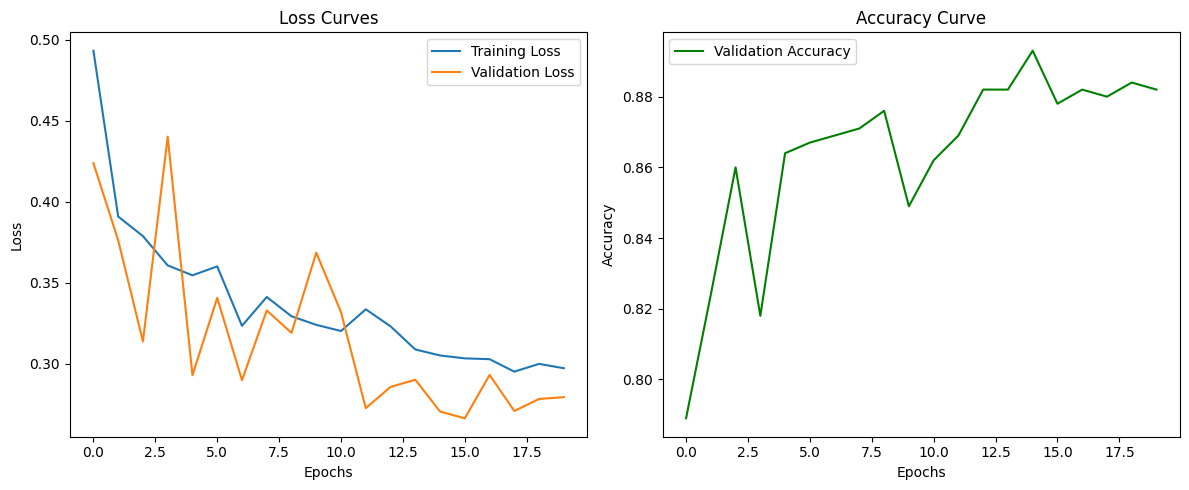

In [20]:
log_history = trainer.state.log_history

train_loss = [entry['loss'] for entry in log_history if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]
accuracy_ = [entry['eval_Accuracy'] for entry in log_history if 'eval_Accuracy' in entry]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Training Loss")
plt.plot(eval_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
predictions = trainer.predict(tokenized_data['validation'])

logits = predictions.predictions
labels = predictions.label_ids

metrics = compute_metrics((logits, labels))
print(metrics)

{'Accuracy': np.float64(0.887), 'AUC': np.float64(0.949)}


### Pushing to HuggingFace

In [22]:
model.push_to_hub("dhruvyadav89300/BERT-phishing-classifier")

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/dhruvyadav89300/BERT-phishing-classifier/commit/4593be3c148dab5570c93824dcdc71bb37159a52', commit_message='Upload BertForSequenceClassification', commit_description='', oid='4593be3c148dab5570c93824dcdc71bb37159a52', pr_url=None, repo_url=RepoUrl('https://huggingface.co/dhruvyadav89300/BERT-phishing-classifier', endpoint='https://huggingface.co', repo_type='model', repo_id='dhruvyadav89300/BERT-phishing-classifier'), pr_revision=None, pr_num=None)